In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from scipy import stats
from termcolor import colored
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import plot_importance
%matplotlib inline


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# load data
import pandas as pd
filename='demotrain6.xlsx'
dataset = pd.read_excel(filename)

In [2]:
dataset.head(10)

,INCOME_DESC,Total_sales,total_visits,median_basket,avg_price,Sensitivity
0,35-49K,3701.91,73,48.50,2.521737,Sensible
1,50-74K,2440.62,43,40.67,2.690871,Not sensible
2,25-34K,4387.35,96,34.35,2.865676,Not sensible
3,75-99K,11205.15,231,40.75,5.793769,Sensible
4,50-74K,1486.02,93,13.73,2.936798,Not sensible
5,Under 15K,4916.05,119,36.49,5.057665,Not sensible
6,100-124K,5561.20,126,29.90,3.637148,Sensible
7,15-24K,9877.49,363,14.72,2.446740,Not sensible
8,75-99K,6186.61,326,15.50,3.622137,Not sensible
9,75-99K,5204.30,111,49.62,3.880910,Sensible


In [3]:
import collections
from collections import Counter

target = dataset.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=Sensible, Count=247, Percentage=32.846%
Class=Not sensible, Count=505, Percentage=67.154%


In [4]:
X=dataset.drop(columns=['Sensitivity'])
Y=dataset['Sensitivity']

In [5]:
# encode string class values as integers
label_encoder = preprocessing.LabelEncoder()
label_encoder = label_encoder.fit(dataset['Sensitivity'])
label_encoded_y = label_encoder.transform(dataset['Sensitivity'])

X['INCOME_DESC'].replace(['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)

# Encoding the categorical data
#labelencoder_X_1 = LabelEncoder()
#X['AGE_DESC'] = labelencoder_X_1.fit_transform(X['AGE_DESC'])

#labelencoder_X_2 = LabelEncoder()
#labelencoder_X_2.fit(["Under 15K", "15-24K", "25-34K", "35-49K", "50-74K", "", "75-99K", "100-124K", "125-149K", "150-174K", "175-199K", "200-249K", "250K+"])
#X['INCOME_DESC'] = labelencoder_X_2.transform(X['INCOME_DESC'])

#labelencoder_X_2 = LabelEncoder()
#X['MARITAL_STATUS_CODE'] = labelencoder_X_2.fit_transform(X['MARITAL_STATUS_CODE'])
#labelencoder_X_3 = LabelEncoder()


In [6]:
from pandas import set_option
set_option('display.width', 100)
set_option('precision', 3)
correlations = dataset.corr(method='pearson')
print(correlations)


               Total_sales  total_visits  median_basket  avg_price
Total_sales          1.000         0.517          0.348      0.345
total_visits         0.517         1.000         -0.300      0.003
median_basket        0.348        -0.300          1.000      0.240
avg_price            0.345         0.003          0.240      1.000


In [7]:
#permet d'avoir le skewness par ordre décroissant des variables
num_feats=dataset.dtypes[dataset.dtypes!='object'].index
skew_feats=dataset[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
print(skewness)

                Skew
total_visits   3.466
median_basket  1.918
Total_sales    1.634
avg_price      1.449


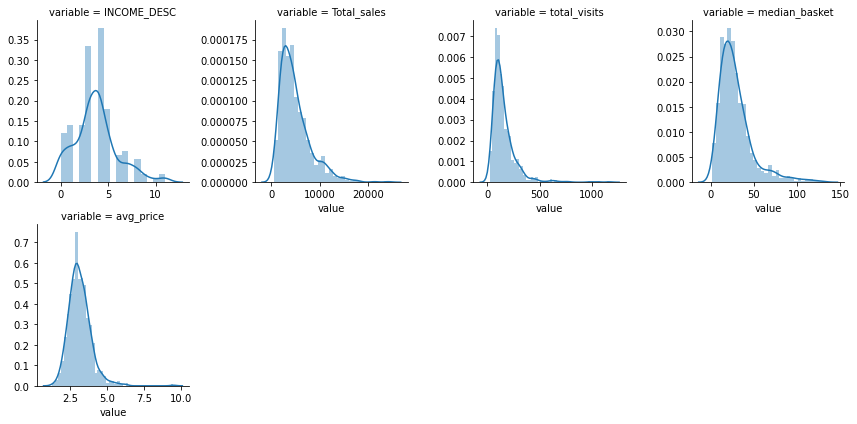

In [8]:
df = pd.DataFrame(data=X, columns=[  'INCOME_DESC', 'Total_sales','total_visits','median_basket','avg_price'])
#Permet de tracer les courbes de distribution de toutes les variables
nd = pd.melt(df, value_vars =df )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,Y ,
test_size=0.25, random_state=7)
#label_encoded_y

In [10]:
from sklearn.preprocessing import PowerTransformer
#instantiate 
pt = PowerTransformer(method='yeo-johnson', standardize=True) 

#Fit the data to the powertransformer
rescaler = pt.fit(X_train)

#Lets get the Lambdas that were found
print (rescaler.lambdas_)

calc_lambdas = rescaler.lambdas_

#Transform the data 
X_train_resc = rescaler.transform(X_train)
X_test_resc=rescaler.transform(X_test)

#Pass the transformed data into a new dataframe 
df_xt = pd.DataFrame(data=X_train_resc, columns=[ 'INCOME_DESC', 'Total_sales','total_visits','median_basket','avg_price'])
# ,
df_xt.head()

df_xt.describe()

[ 0.62396779  0.03385466 -0.1779564   0.07495175 -0.40431864]


,INCOME_DESC,Total_sales,total_visits,median_basket,avg_price
count,5.640e+02,5.640e+02,5.640e+02,5.640e+02,5.640e+02
mean,-1.228e-16,-4.299e-16,2.520e-16,-9.134e-17,-1.071e-16
std,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00
min,-2.027e+00,-2.905e+00,-3.119e+00,-3.156e+00,-3.554e+00
25%,-7.496e-01,-7.234e-01,-6.451e-01,-6.502e-01,-5.950e-01
50%,2.172e-01,1.553e-02,-3.342e-02,5.664e-03,2.498e-02
75%,6.440e-01,6.597e-01,6.756e-01,6.382e-01,6.340e-01
max,2.792e+00,2.985e+00,3.139e+00,2.822e+00,4.490e+00


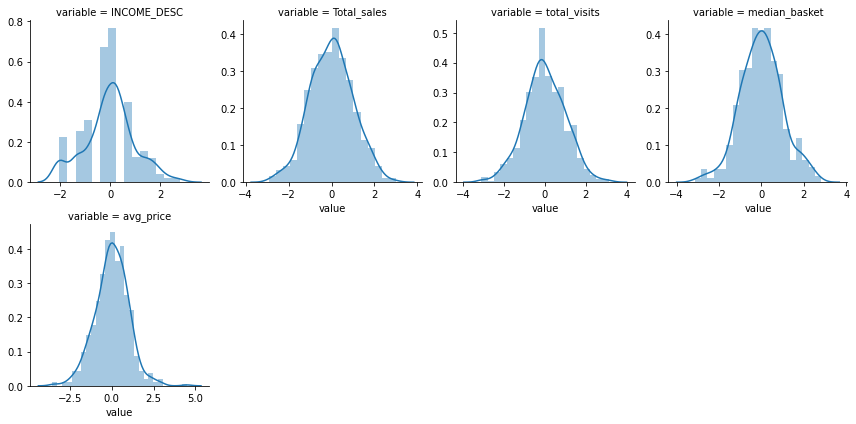

In [11]:
df_xt = pd.DataFrame(data=X_train_resc, columns=[  'INCOME_DESC', 'Total_sales','total_visits','median_basket','avg_price'])
#Permet de tracer les courbes de distribution de toutes les variables
nd = pd.melt(df_xt, value_vars =df_xt )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

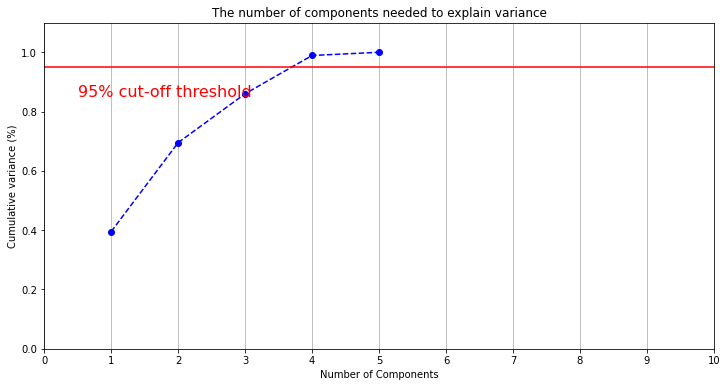

In [12]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_resc)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 6, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [13]:
from sklearn.decomposition import PCA
# on standardized data
pca_std = PCA(n_components=2).fit(X_train_resc)
X_train_std = pca_std.transform(X_train_resc)
X_test_std = pca_std.transform(X_test_resc)
pca_std.explained_variance_ratio_

array([0.39536863, 0.29976652])

In [14]:
#transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [3,4])], remainder='passthrough')
#X = transformer.fit_transform(X)

In [11]:
from imblearn.over_sampling import SMOTE
# up sample only the train dataset with SMOTE
print("Before OverSampling, counts of label 'Sensible': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label 'Not sensible': {} \n".format(sum(y_train==0)))
sm = SMOTE(random_state=42, sampling_strategy = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
    
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label 'Sensible': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label 'Not sensible': {}".format(sum(y_train==0)))

Using Theano backend.
C:\Users\pc\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pc\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pc\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pc\Anaconda3\envs\tensorflow\lib\sit

Before OverSampling, counts of label 'Sensible': 166
Before OverSampling, counts of label 'Not sensible': 337 

After OverSampling, the shape of train_X: (674, 20)
After OverSampling, the shape of train_y: (674,) 

After OverSampling, counts of label 'Sensible': 337
After OverSampling, counts of label 'Not sensible': 337


In [15]:
#check the performance of the XGBoost model without tune parameters
# fit model on training data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
results = cross_val_score(model, X_train_std,y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 62.40% (3.07%)


In [23]:
# grid search to tune algorithm
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_std, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.656084 using {'learning_rate': 0.01, 'n_estimators': 100}
0.647124 (0.017946) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.648894 (0.020607) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.643584 (0.025728) with: {'learning_rate': 0.0001, 'n_estimators': 300}
0.641814 (0.028128) with: {'learning_rate': 0.0001, 'n_estimators': 400}
0.641814 (0.028128) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.640044 (0.026948) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.629377 (0.025496) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.631131 (0.027689) with: {'learning_rate': 0.001, 'n_estimators': 300}
0.638243 (0.021473) with: {'learning_rate': 0.001, 'n_estimators': 400}
0.638227 (0.021055) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.656084 (0.017024) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.652481 (0.014136) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.652434 (0.016324) with: {'learning_rate': 0.01, 'n_estimators': 3

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# fit model on training data
model = xgb.XGBClassifier(learning_rate = 0.01,\
                          n_estimators=100,\
                          objective = 'binary:logistic',\
                          )
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
results = cross_val_score(model, X_train_std,y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 65.61% (1.70%)


In [25]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
model.fit(X_train_std, y_train)

# make predictions for test data
predictions = model.predict(X_test_std)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 69.15%
              precision    recall  f1-score   support

Not sensible       0.71      0.90      0.80       126
    Sensible       0.57      0.26      0.36        62

    accuracy                           0.69       188
   macro avg       0.64      0.58      0.58       188
weighted avg       0.67      0.69      0.65       188



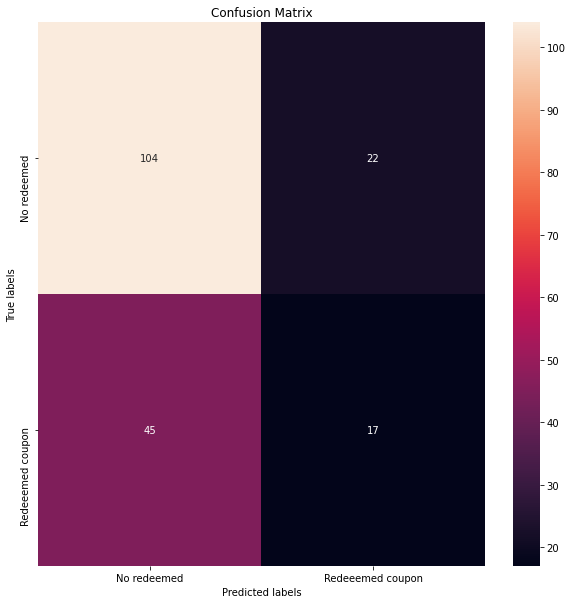

In [18]:
import seaborn as sb
import sklearn as sk
import matplotlib.pyplot as plt
# confusion marix for the test data
cm = sk.metrics.confusion_matrix(y_test, predictions)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No redeemed', 'Redeeemed coupon']); 
ax.yaxis.set_ticklabels(['No redeemed', 'Redeeemed coupon']);

In [20]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_std)
# train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
# eval model
    select_X_test = selection.transform(X_test_std)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
    accuracy*100.0))



Thresh=0.459, n=2, Accuracy: 62.77%
Thresh=0.541, n=1, Accuracy: 66.49%


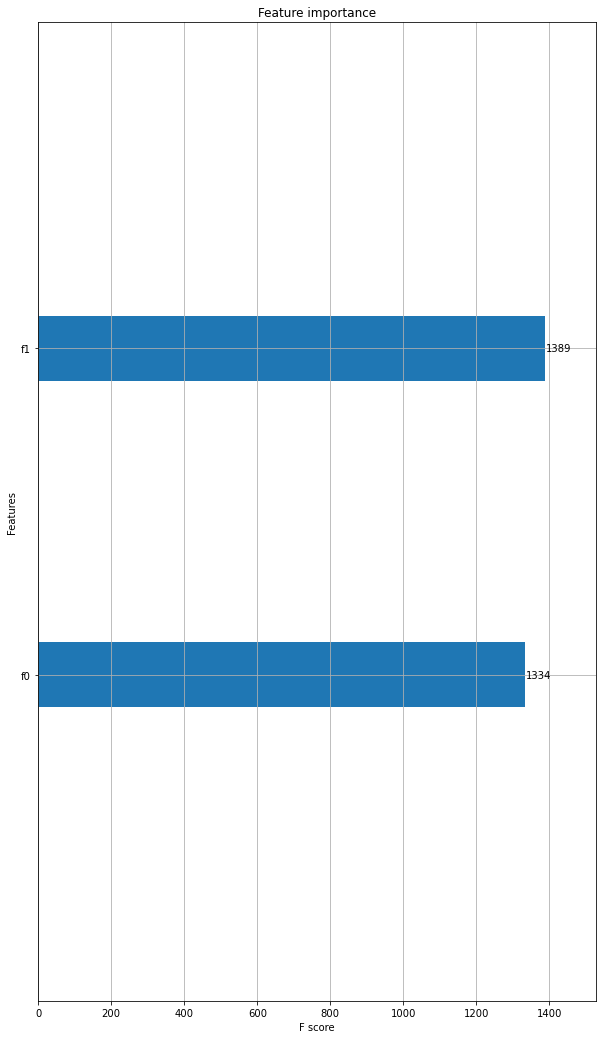

In [21]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);
